In [30]:
print(sns.husl_palette().as_hex())

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


2844it [00:00, 9114.14it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1467it [00:00, 6547.20it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
1686it [00:00, 6775.74it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
10715it [00:01, 5608.67it/s]


<Figure size 432x288 with 0 Axes>

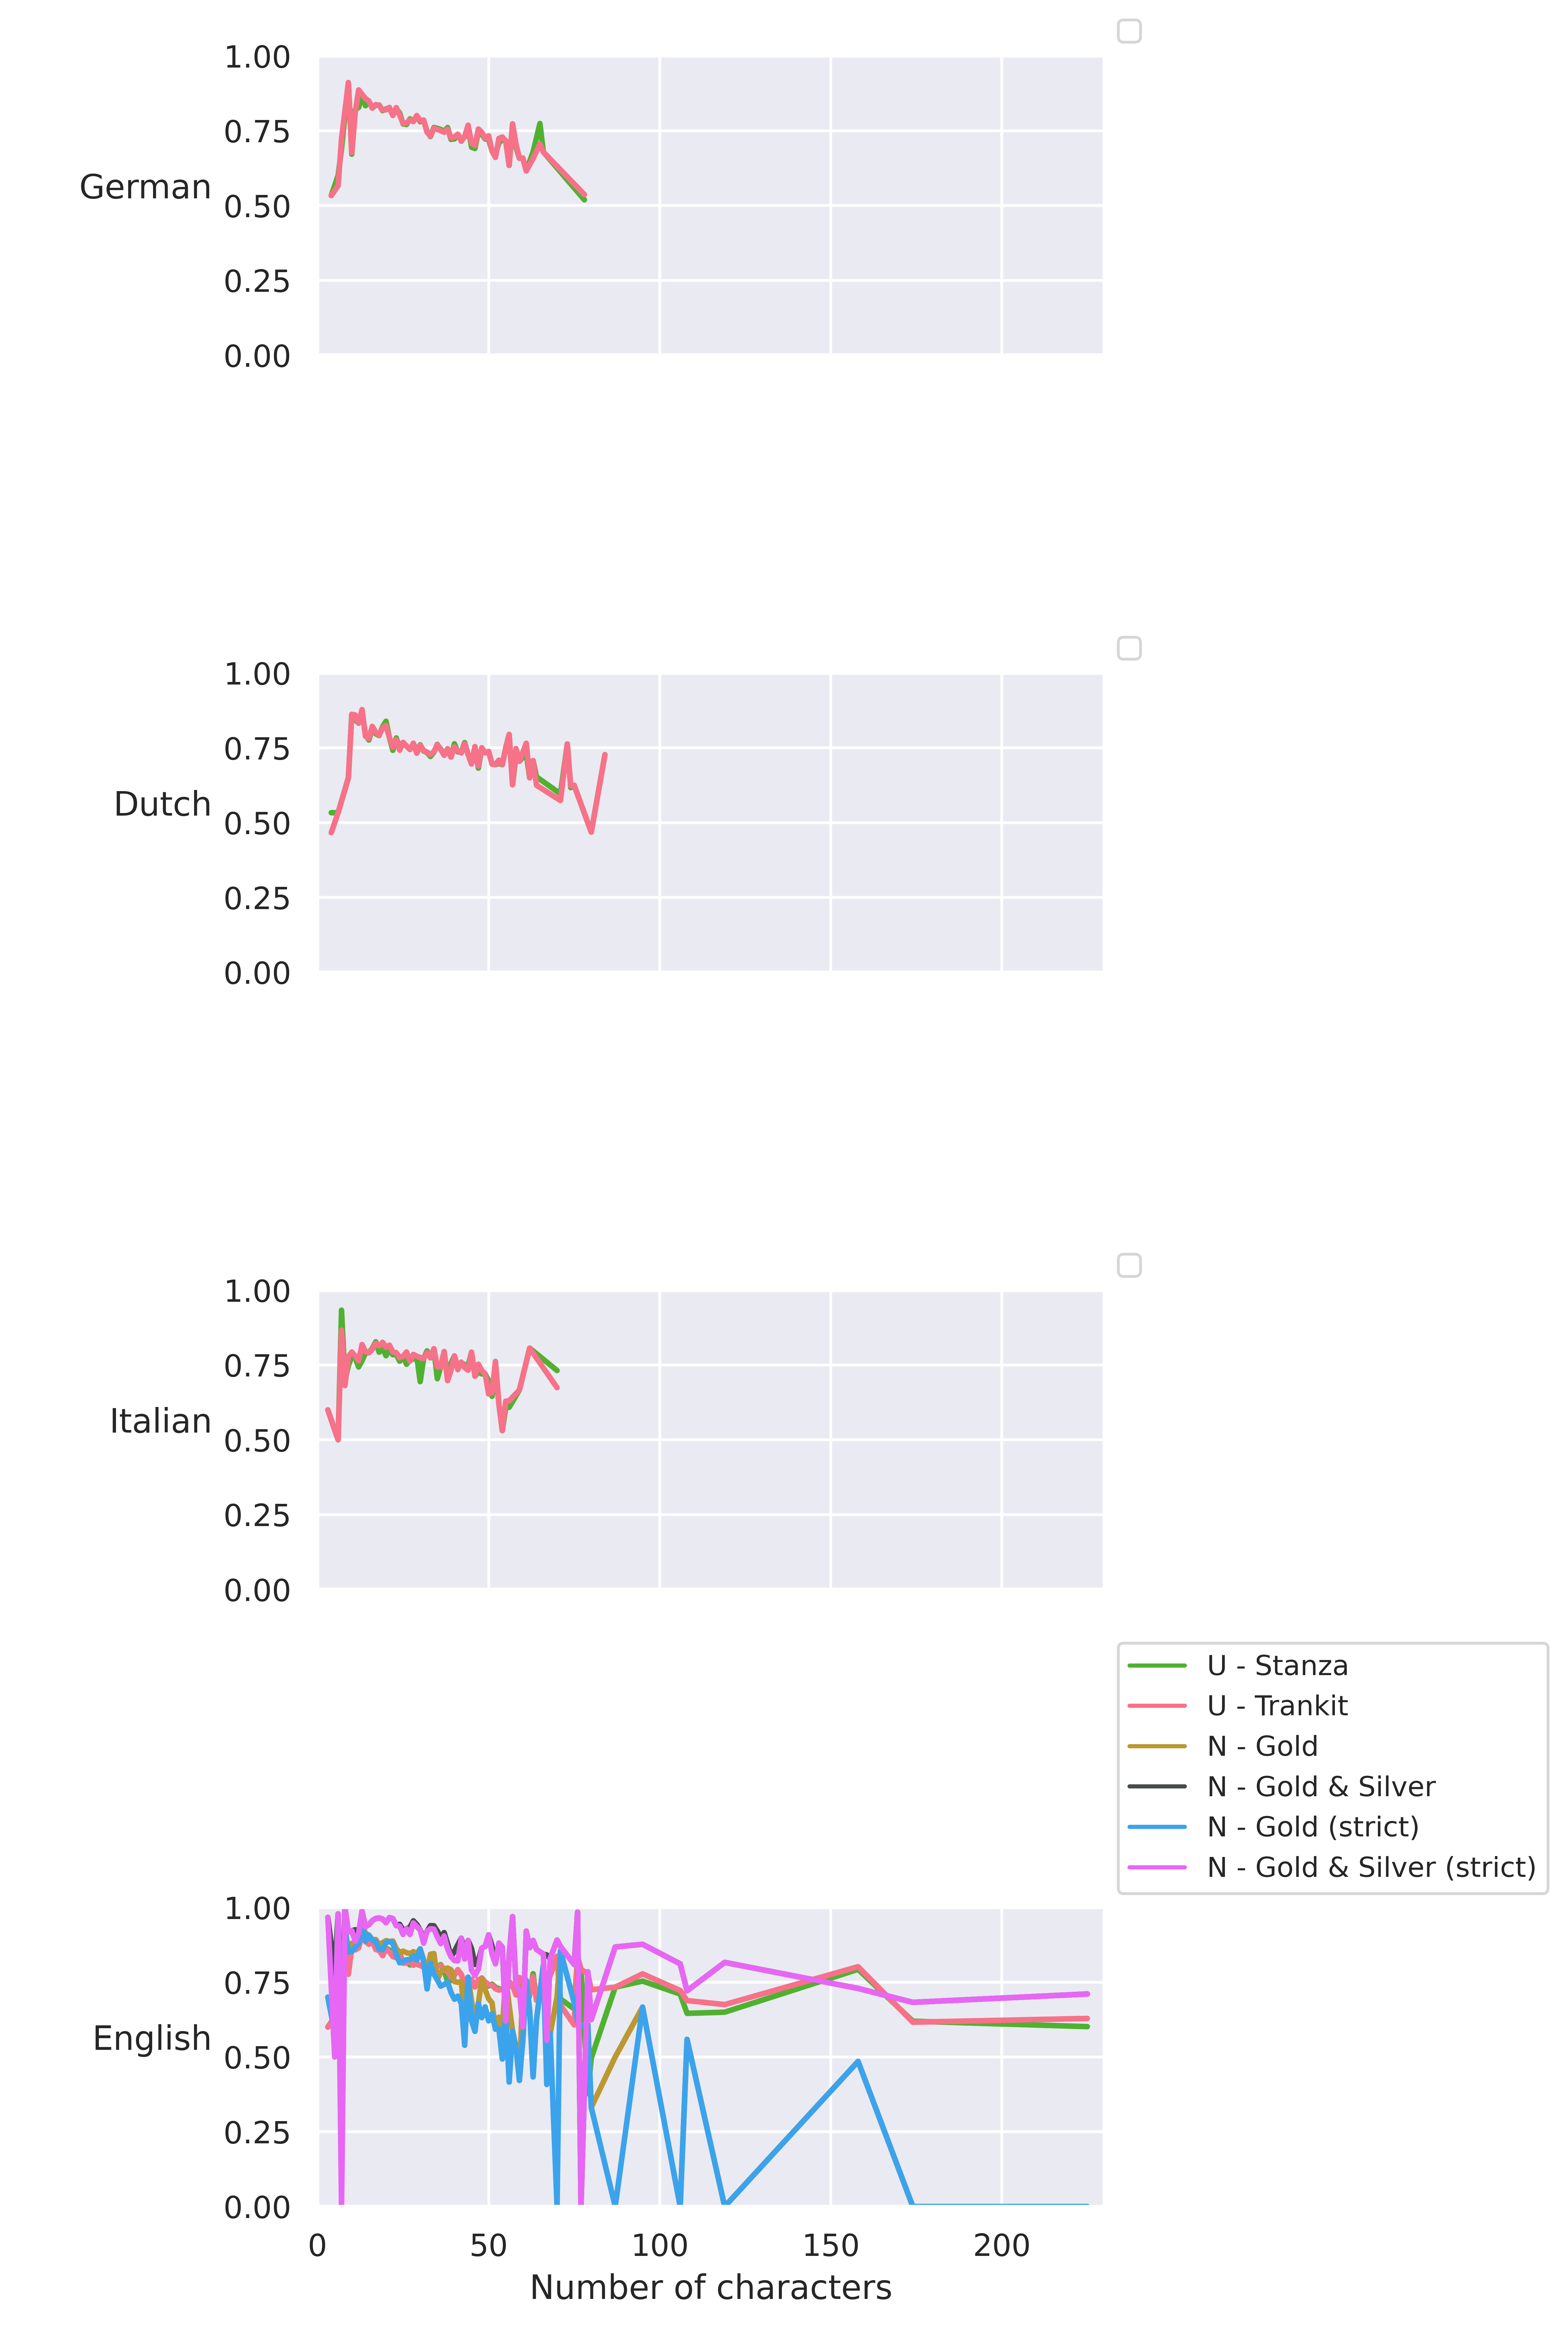

In [11]:
import pandas as pd
from ud_boxer.helpers import PMB
from ud_boxer.sbn_spec import get_doc_id
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
sns.despine()

DPI = 200

lang_mapping = {
    "en": "English",
    "de": "German",
    "nl": "Dutch",
    "it": "Italian",
}

placement = {
    0: (0),
    1: (1),
    2: (2),
    3: (3),
}

palette = {
    "U - Stanza": "#50b131",
    "U - Trankit": "#f77189",
    "N - Gold": "#bb9832",
    "N - Gold & Silver": "#464d49",
    "N - Gold (strict)": "#3ba3ec",
    "N - Gold & Silver (strict)": "#e866f4",
}

fig, axes = plt.subplots(4, 1, figsize=(8, 12), dpi=700)

for i, lang in enumerate(["de", "nl", "it", "en"]):
    df = pd.DataFrame()
    for data_split in ["eval", "dev", "test"]:
        if lang != "en" and data_split == "eval":
            continue

        s_df = pd.read_csv(
            f"data/results/rewrite/{lang}/{data_split}/final_stanza.csv"
        )
        t_df = pd.read_csv(
            f"data/results/rewrite/{lang}/{data_split}/final_trankit.csv"
        )
        s_df["ud_system"] = "U - Stanza"
        t_df["ud_system"] = "U - Trankit"

        df = pd.concat([df, s_df, t_df], ignore_index=True)

        if lang == "en":
            g_df = pd.read_csv(
                f"data/results/seq2seq/{data_split}/results_{data_split}_gold_only.csv"
            )
            gs_df = pd.read_csv(
                f"data/results/seq2seq/{data_split}/results_{data_split}_gold_and_silver.csv"
            )
            g_df["ud_system"] = "N - Gold"
            gs_df["ud_system"] = "N - Gold & Silver"

            df = pd.concat([df, g_df, gs_df], ignore_index=True)

            g_df = pd.read_csv(
                f"data/results/seq2seq/{data_split}/results_strict_indices_gold.csv"
            )
            gs_df = pd.read_csv(
                f"data/results/seq2seq/{data_split}/results_strict_indices_gold_silver.csv"
            )
            g_df["ud_system"] = "N - Gold (strict)"
            gs_df["ud_system"] = "N - Gold & Silver (strict)"

            df = pd.concat([df, g_df, gs_df], ignore_index=True)

    pmb = PMB(data_split, lang)
    for path in pmb.generator(
        f"../../data/pmb_dataset/pmb-extracted/pmb-4.0.0/data/{lang}/gold",
        "**/*.tok.off",
    ):
        doc_id = get_doc_id(lang, path)
        df.loc[df["pmb_id"] == doc_id, "n_tokens"] = len(
            path.read_text().rstrip().split("\n")
        )

    df['n_char'] = df.raw_sent.map(lambda x: len(x.strip()))

    df["f1"] = df["f1"].fillna(0)

    ax = sns.lineplot(
        x="n_char",
        y="value",
        hue="ud_system",
        ci=None,
        data=pd.melt(
            df[["f1", "n_char", "ud_system"]],
            ["n_char", "ud_system"],
            var_name="Scores",
        ),
        palette=palette,
        linewidth=2.0,
        ax=axes[placement[i]],
        legend=i==3,
    )
    ax.set(ylim=(0, 1.0), xlim=(0, 230), xlabel="", ylabel="")
    if i != 3:
        ax.tick_params(bottom=False)
        ax.set(xticklabels=[])

    if i == 3:
        ax.set(xlabel="Number of characters")

    ax.legend(loc="lower left", facecolor="white", fontsize="10", bbox_to_anchor=(1,1))
    ax.set(ylabel=lang_mapping[lang])
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment="right")
    df.to_csv(f'{lang}_tok.csv', index=False)

fig.supylabel(" ")
# fig.suptitle(f'Scores by input length for {lang_mapping[lang]}')
fig.suptitle(f"")
fig.tight_layout()

fig.savefig(f"analysis/scores_vs_len_new_char.pdf")
